In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from PIL import Image

import pandas as pd
import os

import matplotlib.pyplot as plt

In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
hum_df = pd.read_csv("observations-ecuador_only.csv")
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor()
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])
# Put all the images in a sub-directory of hb_images to make this work
dataset = datasets.ImageFolder('./hb_images/', transform=transform)
labels = []
for i, c_name in enumerate(hum_df['common_name']):
    if c_name not in labels:
        labels.append(c_name)
    dataset.targets[i] = labels.index(c_name)
    
data_loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers = 4)

In [33]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained=True).to(device)
model.eval()
print(sum([p.numel() for p in model.parameters()]))

Using cache found in C:\Users\alexg/.cache\torch\hub\pytorch_vision_v0.9.0


60996202


In [34]:
def img_transform(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

images, labels = next(iter(data_loader))

images = images.to(device) #Transfer images to GPU
labels = labels.to(device) #Transfer labels to GPU

images = Variable(images)
labels = Variable(labels)

with torch.no_grad():
    raw = model(images)
    print(raw.keys())
    aux = raw['aux'][2]
    output = raw['out'][2]
output_predictions = output.argmax(0)
aux_predictions = aux.argmax(0)

RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 4.00 GiB total capacity; 2.35 GiB already allocated; 440.26 MiB free; 2.40 GiB reserved in total by PyTorch)

In [ ]:
fig, ((axs1, axs2), (axs3, axs4), (axs5, axs6)) = plt.subplots(3,2, figsize=(10,9))

r1 = Image.fromarray(output_predictions.byte().cpu().numpy())
r1.putpalette(colors)

axs1.imshow(r1)

r2 = Image.fromarray(output_predictions.byte().cpu().numpy())
r2.putpalette(colors)

axs2.imshow(r2)

orig = images[2].cpu().numpy().transpose((1,2,0))
print(orig.max(), orig.min(), orig.mean(), orig.shape)
axs3.imshow(orig)
axs4.imshow(orig)

# Now for the masking
tmp1 = output_predictions.byte().cpu().numpy() / 3
print(tmp1.shape)
mask1 = np.array([tmp1, tmp1, tmp1]).transpose((1, 2, 0))
masked_image1 = np.multiply(mask1, orig)
axs5.imshow(masked_image1)

tmp2 = aux_predictions.byte().cpu().numpy() / 3
mask2 = np.array([tmp2, tmp2, tmp2]).transpose((1, 2, 0))
masked_image2 = np.multiply(mask1, orig)
axs6.imshow(masked_image2)

In [35]:
# Create a dataset of the masked images
masked_images = torch.zeros((8979, 3, 256, 256))
for i, (images, labels) in enumerate(data_loader):
    images = images.to(device) #Transfer images to GPU
    labels = labels.to(device) #Transfer labels to GPU

    images = Variable(images)
    labels = Variable(labels)

    with torch.no_grad():
        raw = model(images)
        output = raw['out']
    output_predictions = output.argmax(axis=1).unsqueeze(1) / 3
    
    # Create the mask
    tmp = output_predictions / 3 # Makes the mask 0-1
    mask = torch.cat((tmp, tmp, tmp), dim=1)
    
    # Apply the mask
    images_new = images.mul(mask)
    # Put on CPU since my GPU doesn't have enough RAM... LOL
    masked_images[i * 128:128 * i + images_new.shape[0]] = images_new.cpu()

RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 4.00 GiB total capacity; 2.44 GiB already allocated; 344.26 MiB free; 2.49 GiB reserved in total by PyTorch)

In [11]:
# Make a new dataset now only using the masked images
masked_images = torch.load("masked_data.pt")
dataset1 = TensorDataset(masked_images, torch.Tensor(dataset.targets))
data_loader1 = DataLoader(dataset1, batch_size=8, shuffle=False, num_workers = 8)


In [12]:
from TRLCNN import Net

In [13]:
model = Net().to(device)
images, labels = next(iter(data_loader1))

output = model(images.to(device))
print(output.shape)

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 4.00 GiB total capacity; 2.71 GiB already allocated; 92.26 MiB free; 2.74 GiB reserved in total by PyTorch)

In [ ]:
free_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(free_params)

trainstep = 125
num_epochs = 25
# Loss and optimizer

criterion = nn.NLLLoss() #You can modify the loss function
optimizer = optim.Adam(model.parameters(), lr=0.01) #You can change the optimizer

# Train the model

total_step = len(data_loader1)
print(total_step)
loss_list = []
acc_list = []
test_acc = []
test_loss_list = []

for epoch in range(num_epochs):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data_loader1):

        images = images.to(device) #Transfer images to GPU
        labels = labels.to(device) #Transfer labels to GPU

        images = Variable(images)
        labels = Variable(labels)
        # Run the forward pass
        outputs = model(images)

        loss = criterion(outputs, labels) #+ model.trl.penalty()
        
        loss_list.append(loss.item())

        # Backprop 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

         # Track the accuracy
        total = labels.size(0) + total
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item() + correct
        acc_list.append(correct / total)

#         if (i + 1) % trainstep == 0:
#             w = torch.nn.utils.parameters_to_vector(model.parameters())
#             correct_test = 0
#             total_test = 0
#             total_loss = 0
#             for images_test, labels_test in testloader:
#                 images_test = images_test.cuda(non_blocking=True)
#                 labels_test = labels_test.cuda(non_blocking=True)

#                 images_test = Variable(images_test)
#                 labels_test = Variable(labels_test)

#                 outputs_test = model(images_test)
#                 test_loss = criterion(outputs_test, labels_test)
#                 total_loss += test_loss.item()
#                 _, predicted_test = torch.max(outputs_test.data, 1)
#                 total_test += labels_test.size(0)
#                 correct_test += (predicted_test == labels_test).sum().item()
#             test_loss_list.append(total_loss / len(testloader))
#             # Don't print test accuracy, but use the results to plot the data
#             test_acc.append(correct_test/total_test)
    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                  (correct / total) * 100)) 

print('Finished Training')

In [14]:
torch.save(torch.Tensor(dataset.targets), "masked_data_labels.pt")

In [23]:
means = torch.mean(masked_images, dim=(1,2,3))
count = torch.sum(means > 0)

In [24]:
count

tensor(6142)

In [25]:
6142/8979

0.6840405390355273

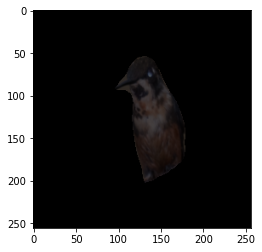

In [31]:
plt.clf()
plt.imshow(masked_images[2].numpy().transpose((1,2,0)))

In [41]:
torch.mean(masked_images[2])

tensor(0.)

In [43]:
images, labels = next(iter(data_loader))

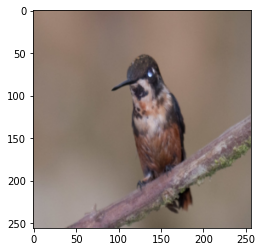

In [45]:
plt.imshow(images[2].numpy().transpose((1,2,0)))

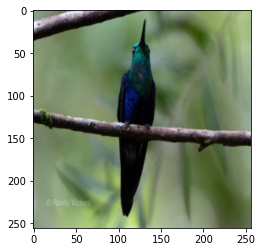

In [46]:
plt.imshow(images[6].numpy().transpose((1,2,0)))

In [47]:
hum_df

,image_url,tag_list,description,place_county_name,species_guess,scientific_name,common_name,iconic_taxon_name,taxon_id
0,https://static.inaturalist.org/photos/151393/m...,NaN,This flower was common near an active nest of ...,Santo Domingo de los Colorados,Hoary Puffleg,Haplophaedia lugens,Hoary Puffleg,Aves,6262
1,https://static.inaturalist.org/photos/165857/m...,NaN,NaN,NaN,Empress Brilliant,Heliodoxa imperatrix,Empress Brilliant,Aves,5919
2,https://static.inaturalist.org/photos/165859/m...,NaN,NaN,NaN,Rufous-tailed Hummingbird,Amazilia tzacatl,Rufous-tailed Hummingbird,Aves,5676
3,https://static.inaturalist.org/photos/165862/m...,NaN,NaN,NaN,Booted Racket-tail,Ocreatus underwoodii,Booted Racket-tail,Aves,5858
4,https://static.inaturalist.org/photos/165864/m...,NaN,NaN,NaN,Long-tailed Sylph,Aglaiocercus kingii,Long-tailed Sylph,Aves,367513
5,https://inaturalist-open-data.s3.amazonaws.com...,NaN,NaN,NaN,Buff-winged Starfrontlet,Coeligena lutetiae,Buff-winged Starfrontlet,Aves,6237
6,https://inaturalist-open-data.s3.amazonaws.com...,NaN,"Amazilia tzacatl\r\nMilpe, Ecuador",NaN,Rufous-tailed Hummingbird,Amazilia tzacatl,Rufous-tailed Hummingbird,Aves,5676
7,https://inaturalist-open-data.s3.amazonaws.com...,NaN,"Amazilia franciae\r\nMilpe, Ecuador",NaN,Andean Emerald,Amazilia franciae,Andean Emerald,Aves,5746
8,https://inaturalist-open-data.s3.amazonaws.com...,NaN,"Ocreatus underwoodii\r\nTandayapa Lodge, Ecuador",NaN,Booted Racket-tail,Ocreatus underwoodii,Booted Racket-tail,Aves,5858
9,https://inaturalist-open-data.s3.amazonaws.com...,NaN,"Aglaiocercus coelestis \r\nTandayapa Lodge, E...",NaN,Violet-tailed Sylph,Aglaiocercus coelestis,Violet-tailed Sylph,Aves,5887
